# <center>Big Data &ndash; Exercises &ndash; Solution</center>
## <center>Fall 2022 &ndash; Week 5 &ndash; ETH Zurich</center>
## <center>Wide Column Stores - HBase</center>

This exercise will consist of four main parts: 
* Hands-on practice with your own HBase cluster running in Docker
* Architecture of HBase
* Bloom filter
* Log-structured merge-tree (LSM tree, optional)

# Exercise 1 &mdash; Creating and using an HBase cluster

It's time to touch HBase! You will create, fill with data, and query an HBase cluster running on Docker.

### Start HBase in the exercise05 folder

Start by getting your docker desktop runnning. 

Through the command line, navigate into the folder (`exercise05`) containing this jupyter notebook and run `docker-compose -f docker-compose.yml up -d`. 

After HBase has been configured, you should see the following messages. 

```sh
exercise05 % docker-compose -f docker-compose.yml up -d
Starting exercise05_zookeeper_1          ... done
Starting exercise05_hbase-regionserver_1 ... done
Starting exercise05_hbase-master_1       ... done
```

You will see all containers running in the docker desktop:
<img src="https://cloud.inf.ethz.ch/s/GQxRfRHTQ2yNgRY/download" style="width:300px;"> <br>

Navigate to `exercise05_hbase-master_1` and open the CLI. 
<img src="https://cloud.inf.ethz.ch/s/dQWHaXyjH6HkY8J/download" style="width:500px;"> <br>

You can now run the commands with `exercise05_hbase-master_1` after opening the CLI. 

You should see a new terminal is open and the messages similar to the following are emitted. 

```hbase
Last login: Wed Oct 19 13:29:14 on ttys007
docker exec -it ec22073e9ab137cc6dfe0fd6c1464e59ba4aa8795275a703134e6949c9f1dfeb /bin/sh
(base) xxx@staff-net-lee-1111 ~ % docker exec -it ec22073e9ab137cc6dfe0fd6c1464e59ba4aa8795275a703134e6949c9f1dfeb /bin/sh
/ # 
```

### Interact with your HBase cluster using the shell

In this task we will go through some basic HBase commands. 

Open the HBase shell by running the following command in the `exercise05_hbase-master_1` CLI.

**`hbase shell`**

Let's say we want to create an HBase table that will store sentences adhering to the structure subject-verb-object (e.g., "I eat mangoes", "She writes books") in different languages. Here is a schema that we may use:

Table name = `sentences`
* Column family: `words`
  * column: `subject`
  * column: `verb`
  * column: `object`
* Column family: `info`
  * column: `language`

With the following command we can create such a table (a description of HBase shell commands is available [here](https://learnhbase.wordpress.com/2013/03/02/hbase-shell-commands/)):

**`create 'sentences', 'words', 'info'`**

You can see the schema of the table with this command:

**`describe 'sentences'`**

Let's insert some sentences into our table. We will put data cell by cell with the command `put <table>, <rowId>, <columnFamily:columnQualifier>, <value>`:

**`put 'sentences', 'row1', 'words:subject', 'I'`**

**`put 'sentences', 'row1', 'words:verb', 'drink'`**

**`put 'sentences', 'row1', 'words:object', 'coffee'`**

Now, let's try to query this sentence from the table:

**`get 'sentences', 'row1'`**

You should see output similar to this:

```
COLUMN                                   CELL
 words:object                            timestamp=1602785046682, value=coffee
 words:subject                           timestamp=1602785045625, value=I
 words:verb                              timestamp=1602785045849, value=drink
3 row(s) in 0.0910 seconds
```

As you can see, HBase shell returns data as key-value pairs rather than as rows literally. You may also notice that the lines are *lexicographically* sorted by the key, which is why "subject" appears after "object" in the list.

I don't know about you, but I like tea more than coffee, so let me update our sentence...

**`put 'sentences', 'row1', 'words:object', 'tea'`**

As you can see, we are using the same `put` command to *update* a cell. But remember that HBase does not actually update cells in place&mdash;it just inserts new versions instead. If you now run the query again, you will see the new data:

**`get 'sentences', 'row1'`**

returns:

```
COLUMN                                   CELL
 words:object                            timestamp=1602785160890, value=tea
 words:subject                           timestamp=1602785045625, value=I
 words:verb                              timestamp=1602785045849, value=drink
3 row(s) in 0.0200 seconds
```

We actually wanted to store sentences in different languages, so let's first set the language for the existing one:

**`put 'sentences', 'row1', 'info:language', 'English'`**

Note that we are now inserting a value into a different column family but for the same row. Verify with a `get` that this took effect. 

Now, let's add a sentence in another language (note that we are using another rowID now&mdash;`row2`):

**`put 'sentences', 'row2', 'words:subject', 'Ich'`**

**`put 'sentences', 'row2', 'words:verb', 'trinke'`**

**`put 'sentences', 'row2', 'words:object', 'Wasser'`**

**`put 'sentences', 'row2', 'info:language', 'Deutsch'`**

Let's check that we indeed have 2 rows now:

**`count 'sentences'`**

Now, let's query all rows from the table:

**`scan 'sentences'`**

This, indeed, returns all two rows, in key-value format as before.


Of course, you can also scan by column family for column:

**`scan 'sentences', {COLUMNS => 'info'}`**

**`scan 'sentences', {COLUMNS => 'info:language'}`**

You can also scan by row ranges (note min incl., max excl.):

**`scan 'sentences', {STARTROW=>'row1', ENDROW=>'row3'}`**

It is, of course, possible to do some filtering in queries:

**`scan 'sentences', {FILTER => "ValueFilter(=, 'binary:English')"}`**

**`scan 'sentences', {COLUMNS => 'words:subject', FILTER => "ValueFilter(=, 'substring:I')"}`**

**`scan 'sentences', {COLUMNS => 'words:object', ROWPREFIXFILTER => 'row'}`**

What if we want to store a sentence that also contains an adjective, in addition to the subject, verb, and object? This is not a problem with HBase, because we can create new columns inside *existing* column families on the fly:

**`put 'sentences', 'row3', 'words:subject', 'Grandma'`**

**`put 'sentences', 'row3', 'words:verb', 'bakes'`**

**`put 'sentences', 'row3', 'words:adjective', 'delicious'`**

**`put 'sentences', 'row3', 'words:object', 'cakes'`**

This row now has more columns in the `words` column family than others:

**`get 'sentences', 'row3'`**

We can also add new columns to existing rows:

**`put 'sentences', 'row1', 'words:adjective', 'hot'`**

**`get 'sentences', 'row1'`**

Let's see what happens if you update a value in an existing column:

**`put 'sentences', 'row1', 'words:adjective', 'cold'`**

You should notice that the time stamp of the column `words:adjective` has been updated.

When you are done with the queries, simply type `exit` to quit the hbase shell.

Note: to drop a table in HBase, first `disable <table>` then `drop <table>`.

# Exercise 2 &mdash; The Wikipedia dataset

In this task we will see how HBase will handle a large dataset, as well as learn about the filters and caching in HBase. We first import a dataset from a csv file and then run queries against it.

The provided dataset comprises approximately the meta data of articles from the English Wikipedia. You will see the following variables in the csv file: 

| variable | meaning | Sample value|
|:------|:---------------|:---------------|
|`page_id`| the page id in the enwiki data dump |1000108|
|`page_title`| the page id in the enwiki data dump |AEG Z.6|
|`page_ns`| page namespace|0|
|`revision_id`| the id of revision to the article |16782282|
|`timestamp`| the time a contributor makes a revision |2004-09-19T23:44:33Z|
|`contributor_id`| the id of contributor |8817|
|`contributor_name`| the name of contributor |Rlandmann|
|`bytes`| bytes in revision |21|


We will use the `wiki_small` data (87.6 MB in csv) in this assignment because it takes shorter time (about 5-10 minutes) to load into HBase.

Based on the descriptives about the variables above, we can categorize the variables into some about a page and others about an author/contributor.

Let us create the schemas in HBase now with two column families `page` and `author`

**`hbase shell`**

**`create 'wiki_small', 'page', 'author'`**

After the table is created, we need to **exit** the HBase shell and return back to the `exercise05_hbase-master_1` CLI by inputting **`exit`**. 

Now we need to populate both tables with data. We will use the [ImportTsv](https://hbase.apache.org/book.html#importtsv) utility of HBase. 

Populate the table `wiki_small` by running the following command. We need to specify which column in the csv maps to which column in the HBase table. Note that we make `page_id` into the `HBASE_ROW_KEY`. Note that these commands print a lot of messages, but they are mostly informational with an occasional non-critical warning; unless something goes wrong, of course :) The commands will also report some "Bad Lines", but you can safely ignore this&mdash;some lines may contain illegal characters and be dropped, but most of the data is in good shape.

There are two steps here. <br>

**Step 1: Copy the csv file from your local file system to the docker container of your HBase master `exercise05_hbase-master_1`.**
Run this command under the directory `exercise05`:
```sh
docker cp ./HBase/enwiki-20200920-pages-articles-multistream_small.csv exercise05_hbase-master_1:/
```
If you go into the `exercise05_hbase-master_1` CLI and do `ls` you should be able to see this csv file is now listed there. 
<br> Note that the HMaster might be named differently across various OS, in that the "hyphen" and "underscore" might look different. In our tests, we have seen variants like `exercise05_hbase-master_1`, `exercise05-hbase-master-1`. Please make sure you double check the naming in your environment when executing the command above. 
<br>

**Step 2: Upload this csv to HBase.**
Run this command after your are in the `exercise05_hbase-master_1` CLI:
```hbase
hbase org.apache.hadoop.hbase.mapreduce.ImportTsv -Dimporttsv.separator=, -Dimporttsv.columns="HBASE_ROW_KEY,page:page_title,page:page_ns,page:revision_id,author:timestamp,author:contributor_id,author:contributor_name,page:bytes" wiki_small enwiki-20200920-pages-articles-multistream_small.csv
```

Note here how we specify the mappings between the csv columns and the `<columnFamily:columnQualifier>` in the HBase table.


Now you can count how many rows there are using this command from your head node's shell:
**`hbase org.apache.hadoop.hbase.mapreduce.RowCounter 'wiki_small'`**

The number of rows after uploading should be **887784**.


Now let's go into HBase shell again and run some queries against the `wiki_small` table. We will look at some of the filters listed by HBase if you run `show_filters` in an HBase shell, e.g., `PrefixFilter(), ValueFilter(), SingleColumnValueFilter()`.



## Tasks to do with the table `wiki_small`

1. How does HBase index the row keys? 
We choose `page_id` in the original table to be the row keys in the HBase table. Run these two queries and what do you observe? What can we say about row key indexing based their results? 

    **`scan 'wiki_small', {STARTROW=>'100009', ENDROW=>'100011'}`**

    **`scan 'wiki_small', {STARTROW=>'100015', ENDROW=>'100016'}`**

1. Write the following queries:
  1. Select all article titles where the row name starts with '`1977`'
  1. Select all author names where the author contains the substring '`tom`'. 
  1. Execute your queries on Question 2.A more than once and observe the query execution times. 
1. Write the following queries:
  1. Return the number of articles from 2017.
  1. Return the number of articles that contain the word `Attacks` on them (case-insensitive). Please discuss different possibilities to formulate this query. 

1. How can we use `SingleColumnValueFilter` to filter multiple columns at the some time? Here is the syntax:
`scan '<table_name>',{FILTER=>"SingleColumnValueFilter('<column_family>','<column_qualifier>',<comp_operator>,'condition:<qualifier_value>') AND SingleColumnValueFilter('<column_family>','<column_qualifier>',<comp_operator>,'condition:<qualifier_value>')",COLUMNS=>['column_family']}`. 
Write a query to return all the articles published in 2018, whose article title contains `Attacks` (case-insensitive).

1. What are the advantages and disadvantages of pure row stores?
1. What are the advantages and disadvantages of pure column stores?
1. What are the advantages and disadvantages of wide column stores?
1. What are the advantages and disadvantages of denormalization?

## Solutions

1. **`scan 'wiki_small', {STARTROW=>'100009', ENDROW=>'100011'}`** returns five keys `1000092, 1000102, 1000104, 1000106, 1000108`, **`scan 'wiki_small', {STARTROW=>'100015', ENDROW=>'100016'}`** returns seven keys `100015, 1000151, 1000153, 1000155, 1000156, 1000158, 1000159`. Rows are sorted lexicographically by row key. You may have to pad keys to get the sorting order you really want (without padding 10 is lexicographically smaller than 2). 

1. The two queries: 
    1. All article titles where the row name starts with '1977'.
    Two ways of formulating the queries: 
    
    (1) `scan 'wiki_small', {COLUMNS => 'page:page_title', ROWPREFIXFILTER => '1977'}` 
    
    OR 
    (2) `scan 'wiki_small', {COLUMNS => 'page:page_title', FILTER => "PrefixFilter('1977')"}`.
    
    1. All author names where the author name contains the substring '`tom`':
    
    `scan 'wiki_small', {COLUMNS => 'author:contributor_name', FILTER => "ValueFilter(=, 'substring:tom')"}`
    
    1. Execution times in Question 2.A.
      1. Queries with `ROWPREFIXFILTER` should be much quicker than `PrefixFilter` for Question 2.A, because the filter is applied to the row key rather than to the contents of columns. 
      1. Subsequent invocations of the same command take less time due to caching.

1. The queries counting the rows.
  1. Number of articles from 2017.
      First, see if we manage to get the articles from 2017 using the following query, limit the return rows to five.
      
      `scan 'wiki_small', {COLUMNS =>'author:timestamp', FILTER => "ValueFilter(=, 'substring:2017')", LIMIT=>5}`
  
      Then run 
      
      `scan 'wiki_small', {COLUMNS =>'author:timestamp', FILTER => "ValueFilter(=, 'substring:2017')"}`
      
      , which gives the returned row count 83647. 
      
   1. Return the number of articles that contain the word `Attacks` on them.
   
      Run this query 
      
      `scan 'wiki_small', {COLUMNS =>'page:page_title', FILTER => "ValueFilter(=, 'substring:Attacks')"}`
      
      which returns 96 rows.
      
      Another way of formulating the query is 
      
      `scan 'wiki_small', {FILTER => " SingleColumnValueFilter ('page', 'page_title', =, 'substring:Attacks') "}` 

1. Multiple filters on different columns. Write a query to return all the articles titles published in 2017, whose article title contains `Attacks` (case-insensitive). 
`scan 'wiki_small',{FILTER=>"SingleColumnValueFilter('page','page_title',=,'substring:attacks') AND SingleColumnValueFilter('author','timestamp',=,'substring:2018')",COLUMNS=>['page:page_title', 'author:timestamp']}`
1. **Pure row store:**
  1. Advantages:
    1. Good for workloads with point lookups and updates. A point lookup query returns only one or a small number of distinct rows. Retrieving (updating) a single row is efficient as the row is colocated
  1. Disadvantages:
    1. Scans are more expensive (whole row is always retrieved)
1. **Pure column store:**
  1. Advantages:
    1. Scans are very efficient (only specific columns can be retrieved)
  1. Disadvantages:
    1. To retrieve (or update) a whole row, many random accesses need to be performed
1. **Wide column store:**
  1. Advantages:
    1. Column families offer a 'middle ground' between pure row- and column-oriented storages.  Columns frequently accessed together can be colocated, very wide columns (affecting scan speed) can be isolated into separate column families
    1. Flexible schema (column names stored for each row) offer flexibility for cases where schema is not known upfront (or in cases of sparse columns)
  1. Disadvantages
    1. Performance penalties, point lookups not as fast as pure row store, scans not as fast as pure column store
    1. Storage overhead
1. **Denormalization:**
  1. Advantages:
    1. All operations are either scans or point lookups. No need for expensive joining of multiple relations (all data is colocated or easily mapped)
  1. Disadvantages:
    1. It is difficult to enforce (maintain) consistency in cases of updates
    1. Storage (memory) overhead, due to duplicated data
    1. Scan processing can be more expensive

# Exercise 3 &mdash; Architecture of HBase

In the previous tasks, we have seen HBase in action. Let us now take a look at the internal architecture of HBase. You may want to consult the lecture slides when solving these tasks.

## Task 3.1 &mdash; Inside a RegionServer

In this exercise you will see how a RegionServer in HBase would execute a query.

Imagine that we have an HBase table called '`phrases`', which has the following schema:

* Column family: `words`
  * column: A
  * column: B
  * column: C
  * (potentially also columns D, E, F, etc.)

Thus, the table has only one column family. Each column in this family holds one word.

Recall from the lecture slides that keys in HBase have the following structure:
<img src="https://cloud.inf.ethz.ch/s/jYJmNrzReEXsPJJ/download" width="70%">

We need make certain simplifications to the format of keys to avoid excessive clutter in this exercise. Since the table in this exercise has only one column family, we will omit it from the key and will only specify the column name (A,B,C, ...). We will also omit the length fields and the "key type" field. The timestamp field in this exercise will contain integers from 1 to 10, where in reality it would contain the number of milliseconds since an event in the long past. Thus, keys as will be used in this exercise consist of three fileds: row, column, timestamp.

### Tasks to do

State which Key-Value pairs will be returned by each of the following queries, given in HBase shell syntax which you have already seen in the first exercise. Assume that the HBase instance is configured to return only the latest version of a cell.

1. `get 'phrases', '278'`
1. `get 'phrases', '636'`
1. `get 'phrases', '593'`
1. `get 'phrases', '640'`
1. `get 'phrases', '443'`

To answer this question, use the diagram below, which represents the state of a RegionServer responsible for the row region in the range of row IDs 100&ndash;999, which is the region into which all these queries happen to fall. 

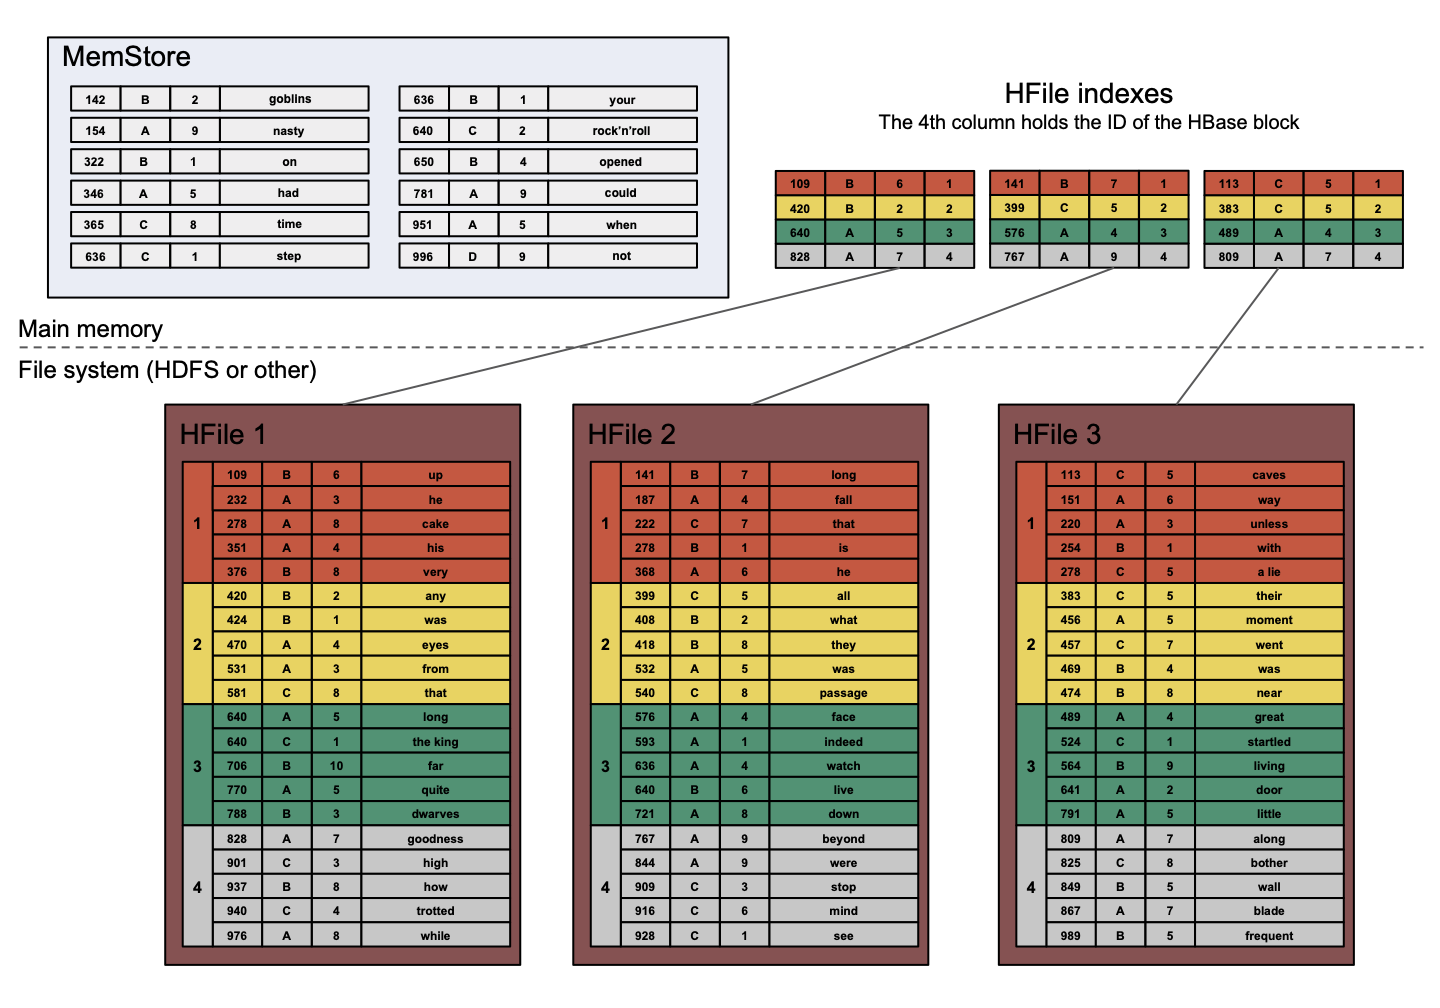


You can format your answer for this exercise as follows

1. get 'phrases', 'row_id' 

| Row | Column | Timestamp | Value | Where it came from (which HFile) |
|:-----:|:-----:|:-----:|:-------|:--------------------:|
||||||
||||||
||||||

## Solution to the Task 3.1

1. get 'phrases', '278' 

| Row | Column | Timestamp | Value | Where it came from |
|:-----:|:-----:|:-----:|:-------|:--------------------:|
|278|A|8|cake|HFile1|
|278|B|1|is|HFile2|
|278|C|5|a lie|HFile3|

2. get 'phrases, '636'

| Row | Column | Timestamp | Value | Where it came from |
|:-----:|:-----:|:-----:|:-------|:--------------------:|
|636|A|4|watch|HFile2|
|636|B|1|your|MemStore|
|636|C|1|step|MemStore|

3. get 'phrases', '593'

| Row | Column | Timestamp | Value | Where it came from |
|:-----:|:-----:|:-----:|:-------|:--------------------:|
|593|A|1|indeed|HFile2|

4. get 'phrases', '640'

| Row | Column | Timestamp | Value | Where it came from |
|:-----:|:-----:|:-----:|:-------|:--------------------:|
|640|A|5|long|HFile1|
|640|B|6|live|HFile2|
|640|C|2|rock'n'roll|MemStore|

Note that "640,C,1 -> the king" (HFile1) got superseded by "640,C,2 -> rock'n'roll".

5. get 'phrases', '443'

The row doesn't exist, so no output.

## Task 3.2 &mdash; Bloom filters

Let's start with summarizing what we have in memory when working with HBase: MemStore, LRU (Least Recently Used) BlockCache, Indices of HFiles, and Bloom Filters. We did not have time to cover BloomFilters in the lecture, but bloom filters are actually very crucial in avoiding disk reads if we can guarantee that a key is **not** in an HFile. Bloom filters allow us to very quickly determine whether an element belongs to a set.

Bloom filters are a data structure used to speed up queries, useful in the case in which it's likely that the value we are looking doesn't exist in the collection we are querying. Their main component is a bit array with all values initially set to 0. When a new element is inserted in the collection, its value is first run through a certain number of (fixed) hash functions, and the locations in the bit array corresponding to the outputs of these functions are set to 1.

This means that when we query for a certain value, if the value has previously been inserted in the collection then all the locations corresponding to the hash function outputs will certainly already have been set to 1. On the contrary, if the element hasn't been previously inserted, then the locations may or may not have already been set to 1 by other elements.

Then, if prior to accessing the collection we run our queried value through the hash functions, check the locations corresponding to the outputs, and find any of them to be 0, we are guaranteed that the element is not present in the collection (No False Negatives), and we don't have to waste time looking. If the corresponding locations are all set to 1, the element may or may not be present in the collection (Possibility of False Positives), but in the worst case we're just wasting time.

Inspect the following examples. Say we have hash functions that map the input `John Smith` and `Mary Smith` to the bit array `011001110000`. When we have a new input `Albert Einstein` which is mapped by the same hash functions to the bit array `000101100000`. This clearly does not correspond to the bit array produced by the previous two inputs. Hence, we can say that `Albert Einstein` is not in the set which `John Smith` and `Mary Smith` belong to (denoted as `{the Smiths}` for short). However, another input `Louis de Broglie` whose bit array after hashing is `010000110000` is then a false positive for the set `{the Smiths}`.

<img src="https://cloud.inf.ethz.ch/s/SjiJpcAQ8bZAfRi/download" width="50%">
<img src="https://cloud.inf.ethz.ch/s/jWC8TDFyXcgyBBx/download" width="50%">
<img src="https://cloud.inf.ethz.ch/s/t788cXTnzcQ2zYC/download" width="50%">
<img src="https://cloud.inf.ethz.ch/s/kfrL2Jo23nJPPe7/download" width="50%">

As you have seen in the task above, HBase has to check all HFiles, along with the MemStore, when looking for a particular key. As an optimisation, Bloom filters are used to avoid checking an HFile if possible. Before looking inside a particular HFile, HBase first checks the requested key against the Bloom filter associated with that HFile. If it says that the key does not exist, the file is not read.

In this task we will look at how Bloom filters work. We will use a list of words to populate a Bloom filter and we will then query it.

Bloom filter requires several hash functions. To keep things easily computable by a human, we will define the following three hash functions for the purpose of this exercise:

1. Given an English word $x$, the value of the first hash function, $hash_1(x)$, is equal to the *first letter of the word*. E.g.: $hash_1($"`federal`"$)$ = "`f`"

1. Given an English word $x$, the value of the second hash function, $hash_2(x)$, is equal to the *second letter of the word*. E.g.: $hash_2($"`federal`"$)$ = "`e`"

1. Given an English word $x$, the value of the third hash function, $hash_3(x)$, is equal to the *third letter of the word*. E.g.: $hash_3($"`federal`"$)$ = "`d`"

A Bloom filter starts with a bit array which has value "0" recorded for each possible output value of all three hash functions (or, for example, modulo the size of the bit array, if the output range of the hash functions is too large).
When we *add* an element to a Bloom filter, we compute the three values of the three hash functions and set those locations in the Bloom filter to "1". For example, if we add "`federal`" to the Bloom filter using the three hash functions that we have defined above, we get the following:

| | | |1|1|1| | | | | | | | | | | | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|

Here, only values "1" are displayed to avoid cluttering the view; thus, if a cell is empty, it is assumed to hold a "0".

**Here is what we will do next.**<br>
Step 1. Create a bloom filter that for a collection of words (Collection A). 
<br>
Step 2. Given this bloom filter, check if a set of new words (Collection B) are members of Collection A. 

**Step 1.** First, populate the following table with the outputs of these hash functions (double-click the table to edit it and hit Ctrl+Enter to exit the editing mode; you are also free to do this task in some other tool, of course):
[**Collection A**]

| Word    | $hash_1$ | $hash_2$ | $hash_3$ |
|:--------|-------------|-------------|-------------|
|round    |             |             |             |
|sword    |             |             |             |
|past     |             |             |             |
|pale     |             |             |             |
|nothing  |             |             |             |
|darkness |             |             |             |
|water    |             |             |             |
|feet     |             |             |             |
|thin     |             |             |             |
|passage  |             |             |             |
|corner   |             |             |             |

Now, *add* each word from the list into the following Bloom filter (you can also double-click to edit it; you can double-click the Bloom filter populated with "federal" above to see an example of a filled-in filter): [**Bloom Filter for Collection A**]

| | | | | | | | | | | | | | | | | | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|

2. For each word from the following list, state whether this Bloom filter reports it as belonging to the set or not (skip filling-in the hash columns, if you want): [**Collection B**]

| Word    | $hash_1$ | $hash_2$ | $hash_3$ | The Bloom filter says the word belongs to the set: (yes/no) |
|:--------|----------|----------|----------|:-----------:|
|sword    |          |          |          |             |
|sound    |          |          |          |             |
|psychic  |          |          |          |             |
|pale     |          |          |          |             |
|book     |          |          |          |             |
|deaf     |          |          |          |             |
|truss    |          |          |          |             |

Which of the words that were flagged by the Bloom filter as belonging to the set are actually **not** in the set (a *false positive* outcome)?

Which of the words that were flagged by the Bloom filter as **not** belonging to the set actually **do belong** to the set (a *false negative* outcome)?

## Solution to the Task 3.2

Hashes for each of the words from the first list: [**Collection A**]

| Word    | hash_1 | hash_2 | hash_3 |
|:--------|-------------|-------------|-------------|
|round    |R            |O            |U            |
|sword    |S            |W            |O            |
|past     |P            |A            |S            |
|pale     |P            |A            |L            |
|nothing  |N            |O            |T            |
|darkness |D            |A            |R            |
|water    |W            |A            |T            |
|feet     |F            |E            |E            |
|thin     |T            |H            |I            |
|passage  |P            |A            |S            |
|corner   |C            |O            |R            |

The Bloom filter with all those words added to it: [**Bloom Filter for Collection A**]


|1| |1|1|1|1| |1|1| | |1| |1|1|1| |1|1|1|1| |1| | | |
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|

For each word from the following list, state whether this Bloom filter marks them as belonging to the set or not:
[**Collection B**]

| Word    | The Bloom filter says the word belongs to the set: (yes/no) | Comment |
|:--------|:-----------:|:-------------|
|sword    | yes            | present in the original list |
|sound    | yes            | not from the original list, but still got flagged as present: this is a *false positive* |
|psychic  | no             | indeed, it's not from the original list |
|pale     | yes            | present in the original list |
|book     | no             | indeed, it's not from the original list |
|deaf     | yes            | a *false positive* |
|truss    | yes            | a *false positive* |

As you can see, a Bloom filter can produce false positive outcomes. Luckily, it never produces false negative outcomes, i.e., if a Bloom filter says that an element is absent from the set, it is guaranteed to really be absent from the set.

## Task 3.3 &mdash; Building an HFile index

As discussed in Task 3.2, HBase uses Bloom filters, stored in the metadata of each HFile, in order to discard all get requests which query data not stored in the HFile. However when performing a get for which the bloom filter returns positive, the RegionServer needs to check its MemStore and all HFiles for the existence of the requested key. In order to avoid scanning HFiles entirely, HBase uses index structures to quickly skip to the position of the *HBase block* which may hold the requested key. Note HBase block is not to be confused with HDFS block and the underlying file system block, see [here](https://blog.cloudera.com/hbase-blockcache-101/#3) for a good discussion. HBase blocks come in 4 varieties: DATA, META, INDEX, and BLOOM.

By default, each *HBase block* is 64KB (configurable) in size and always contains whole key-value pairs, so, if a block needs more than 64KB to avoid splitting a key-value pair, it will just grow. 

In this task, you will be building the index of an HFile. __For the purpose of this exercise__, assume that each HBase block is 40 bytes long, and each character in keys and values is worth 1 byte: for example, the first key-value pair in the diagram below is worth $3 + 1 + 1 + 6 = 11$ bytes. Below this diagram you will find a table for you to fill in.

<img src="https://cloud.inf.ethz.ch/s/96M88qHqpgjGG2c/download" width="60%">

#### Based on the contents of the HFile above, you need to populate the index, following the approach described in the lecture slides. Use the following table (again, you can edit it by double-clicking). Use as many or as few rows as you need.

| RowId | Column | Version |
|-------|--------|---------|
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |

## Solution to the Task 3.3


| RowId | Column | Version |
|-------|--------|---------|
| 113   |   C    |    5    |
| 383   |   C    |    5    |
| 469   |   B    |    4    |
| 641   |   A    |    2    |
| 849   |   B    |    5    |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |
|       |        |         |

![](https://cloud.inf.ethz.ch/s/cHDsWSJgPexPBAY/download)

# Exercise 4 &mdash; Thinking about the schema (optional)

A very important schema design question in HBase is the choice of the row key.

Imagine that you have a dataset containing:
* addresses of websites (URLs), potentially of all websites available online
* for each URL: the country in which the owner of the website is registered
* for each URL and for each country in the world: the number of visits to that URL from that country during the last month

You plan to store this dataset in HBase. For each of the following queries, state what you think is the best choice for the row key:
1. Given a particular URL, count the total number of visits
1. Given a particular country, find the URL that is visited the most by the users from that country
1. Among all URLs whose owners are registered in a particular country, find the most visited one.

## Solution to Exercise 4

1. **Given a particular URL, count the total number of visits.** In this case we can just have the URL as the row key, because we look-up by URL alone.
1. **Given a particular country, find the URL that is visited the most by the users from that country.** Here it is better to have a key consisting of the visitor country and URL concatenated together. This way we will be able to run fast queries with a `ROWPREFIXFILTER`. Note that in this case the owner's country will have to be duplicated for each row that has the same URL in the key, so the data is denormalized.
1. **Among all URLs whose owners are registered in a particular country, find the most visited one.** In this case it makes sense to have the owner's country prepended to the URL for similar reasons as in the previous case.

# Exercise 5 &mdash; Log-structured merge-tree (LSM tree) (optional) 

We learn in the lecture that LSM tree is highly efficient in applications using wide column storage such as HBase, Cassandra, BigTable, LevelDB, where insertions in memory happen quite often. As opposed to B+-tree which has a time complexity of *O(log n)* when inserting new elements, *n* being the total number of elements in the tree, LSM tree has *O(1)* for inserting, which is a constant cost. You can find [more](https://www.oreilly.com/library/view/hbase-the-definitive/9781449314682/ch08.html) details  on this  topic in this week's reading.

The following figure is from the HBase Guide book where we see how a multipage block is merged from the in-memory tree into the next on-disk tree. Trees in the store files are arranged similar to B-trees. Merging writes out a new block with the combined result. Eventually, the trees are merged into the larger blocks.<br>

<img src="https://cloud.inf.ethz.ch/s/tWpjzNKNBPBTPDd/download" width="60%">


Inserting data into LSM Tree:

1. When a write comes, it is inserted in the memory-resident MemStore.
2. When the size of the MemStore exceeds a certain threshold, it’s flushed to the disk.
3. As MemStore is already sorted, creating a new HFile segment from it is efficient enough.
4. Old HFiles are periodically compacted together to save disk space and reduce fragmentation of data.

Reading data from LSM Tree:

1. A given key is first looked up in the MemStore.
1. Then using a hash index it’s searched in one or more HFiles depending upon the status of the compaction.

Deletes are a special case of update wherein a delete marker is stored and is used during the lookup to skip “deleted” keys. When the pages are rewritten asynchronously, the delete markers and the key they mask are eventually dropped.

We will now walk through a concrete exercise to understand how LSM tree works in HBase. Image we have a client who is constantly writing into HBase. The client also occasionally reads and deletes key value pairs in HBase. MemStore and disk are two storages we examine in this assignment. 

<img align="center" width="50%" src="https://cloud.inf.ethz.ch/s/XfJM8Lgpcw7AqKR/download"><br>
The client requests the following operations from HBase in sequence:
1. writing the following key value pairs into HBase: `(C,1), (B,2), (A,9), (A,109), (G,8), (D,67), (Z,0)`;
2. reading the value of key `A`;
3. deleting the key `Z`;
4. writing the following key value pairs: `(S,100), (Z1,900), (A1,9), (A01,1), (A11,1)`. 

In the meanwhile, in HBase flush and compaction are conducted to optimize transfer. 

Please draw the processes of 
1. how the key value pairs are stored in HBase? To simplify the actual key in HBase, we use key[t] to denote the key. E.g., when the client writes the key value pair `(C,1)` into HBase, it is first stored in MemStore with the key value `C[t1] 1`.
<img align="center" width="50%" src="https://cloud.inf.ethz.ch/s/Cyj422d9gjfKcpG/download">
2. how does HBase flush and compact the HFiles? Let us set the threshold of flush to three, i.e., when the key value pairs in MemStore have reached three, HBase will flush them to disk (from $C_0$ to $C_1$). Let us also set the threshold of compaction to three, i.e., if there exist two HFiles, each with three key value pairs, we have to compact them into a bigger HFile (from $C_1$ to $C_2$). The same rule applies for bigger HFiles: whenever there is of factor two some HFile at the level of $C_{k-1}$, compact them to the level $C_k$. 

## Solution to Exercise 5
Here is a chain of operations that would happen. Please read the charts from left to right in a row and then go to the next row.

<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/Cyj422d9gjfKcpG/download"> <!-- LSM02 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/2mzAQTs2xmgAq6M/download"> <!-- LSM03 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/nM76GRisxWozQRi/download"> <!-- LSM05 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/Y59S6i4f6TjgK9y/download"> <!-- LSM06 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/R7cQAJTfJdwMLHE/download"> <!-- LSM07 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/8oigTw83tmybK74/download"> <!-- LSM08 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/WFso5xdtBK4EPBW/download"> <!-- LSM09 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/tEsLDF3DYaQGrEf/download"> <!-- LSM10 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/YoBSqLbL4QwJASD/download"> <!-- LSM11 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/cSqezbnKNybCgyH/download"> <!-- LSM12 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/Qf444GoWAQkFKXo/download"> <!-- LSM13 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/2tSt4QFWH5Mg6a6/download"> <!-- LSM14 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/spFPEHEcyTfLnrm/download"> <!-- LSM15 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/Kfmwm2dJPYM3Af2/download"> <!-- LSM16 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/ZDQLSqnyiArRfer/download"> <!-- LSM17 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/2FpYsA8GEKLHMgr/download"> <!-- LSM18 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/tmie2HCQSomwWD9/download"> <!-- LSM19 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/YyxmzFy5NfqkMCL/download"> <!-- LSM20 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/pSNK7dFr82Kr6gG/download"> <!-- LSM21 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/xs2tekeJJSR4Ytt/download"> <!-- LSM22 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/fEpiopGFBMegQ9R/download"> <!-- LSM23 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/RDCrWMos8jWRCsE/download"> <!-- LSM24 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/RcJnPksa2x83p8T/download"> <!-- LSM25 -->
<img align="right" width="50%" src="https://cloud.inf.ethz.ch/s/5ysfmJgHD6XNGs9/download"> <!-- LSM26 -->
<img align="left" width="50%" src="https://cloud.inf.ethz.ch/s/5cKE7FnGtFnYPec/download"> <!-- LSM26 -->